# Train and Test Our Novel 3D Classifying CNN Model

Notebook Authors: Kyle Lukaszek and Lukas Janik-Jones

### Import Dependencies

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from Scripts import OurCNN
from Scripts import VoxelizeData as vd

# Use GPU if available, has issues with these small batch sizes
if torch.cuda.is_available(): 
    dev = torch.device("cuda")
else: 
    dev = torch.device("cpu")

print(torch.__version__)

# dev = torch.device("cpu")

print(dev)

2.1.0+cu121
cuda


### Load Dataset To Train Model

Change **training_set** to any of the following:

- ModelNet40
- ShapeNet
- Toys4k

If you have 16GB of RAM or less, I recommend using the Toys dataset, and then avoiding the cross-dataset evaluation.

In [3]:
training_set = "ModelNet40"

train_data, train_labels, test_data, test_labels = vd.load_dataset(training_set)

#### Define Training Function

In [4]:
def train_cnn(model, optimizer, criterion, train_loader, batch_size, decay_iter, learning_rate, batch_number, dev):
    # Train cnn
    for (vox_grids, vox_labels) in train_loader:
        vox_grids = vox_grids.to(dev)
        vox_labels = vox_labels.to(dev)

        batch_number += 1

        if batch_number % decay_iter == 0:
            print("Decreasing learning rate")
            learning_rate *= 0.1

        if (len(vox_grids) < batch_size):
            continue

        output = model(vox_grids)
        loss = criterion(output, vox_labels)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_number, learning_rate

#### Define Testing Function

In [5]:
def test_cnn(model, batch_size, num_classes, dataloader):
    num_correct = 0
    total = 0
    predictions_test = []
    labels_test = []

    # Test the model on the training data
    for (grids, labels) in dataloader:
        if (len(grids) < batch_size):
            continue

        grids = grids.to(dev)
        labels = labels.to(dev)

        output = model(grids)

        _, predictions = torch.max(output, 1)

        # Determine the number of correct predictions
        num_correct += (predictions.cpu() == labels.cpu()).sum().item()
                
        # Determine the number of total predictions made
        total += labels.shape[0]
                
        # Store the predictions and labels for calculating the metrics
        predictions_test += predictions.cpu().tolist()
        labels_test += labels.cpu().tolist()
            
    # Calculate the metrics
    accuracy = (num_correct / total) * 100.0
    f1 = f1_score(labels_test, predictions_test, average='weighted')
    mse = mean_squared_error(labels_test, predictions_test)
    conf_matrix = confusion_matrix(labels_test, predictions_test, labels=[i for i in range(num_classes)])

    return accuracy, f1, mse, conf_matrix

#### Find Best Parameters Using Grid Search

No need to run this cell.

In [6]:
# batch_size = 32
# classes = np.unique(train_labels)
# num_classes = len(classes)
# print(num_classes)

# # Make a parameter grid for grid search
# param_grid = {'epochs': [40, 50],
#         'learning_rate': [0.01, 0.001, 0.0001],
#         'momentum': [0.9, 0.95, 0.99, 0.999],
#         'weight_decay': [0.01, 0.001],
#         'decay_iter': [10000, 20000, 40000, 80000]
#         }

# # Store index of the best iteration for each metric
# best_results = {'f1': 0, 'acc': 0, 'mse': 0}

# # Store the f1 score, accuracy, MSEs, and confusion matrices for each parameter combination, as well as the parameters
# metrics = {'f1_scores': [], 'accuracies': [], 'mses': [], 'conf_matrices': []}
# results = {'train': [], 'test': [], 'params': [], 'best': best_results}

# # Load data in batch sizes
# train_loader = vd.build_dataloader(train_data, train_labels, batch_size=batch_size, shuffle=True)
# test_loader = vd.build_dataloader(test_data, test_labels, batch_size=batch_size, shuffle=True)

# best_acc = 0
# best_f1 = 0
# best_mse = float('inf')

# # Apply grid search using the sklearn ParameterGrid
# for i, params in enumerate(ParameterGrid(param_grid)):
#     print(f'iteration {i}: {params}')

#     # Get the parameters
#     learning_rate = params['learning_rate']
#     momentum = params['momentum']
#     weight_decay = params['weight_decay']
#     decay_iter = params['decay_iter']
#     epochs = params['epochs']

#     # Store the metrics for this iteration so we can plot them later
#     results['test'].append(metrics.copy())
#     results['train'].append(metrics.copy())

#     # Store the parameters for this iteration
#     results['params'].append(params)

#     # Initialize the model
#     model = CNN.CNN(num_classes)
#     model = model.float()
#     model.to(dev)

#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
#     criterion = torch.nn.CrossEntropyLoss()

#     batch_number = 0

#     # Train and test the model for the specified number of epochs
#     for epoch in range(epochs):
        
#         batch_number, learning_rate = train_cnn(model, optimizer, criterion, train_loader, batch_size, decay_iter, learning_rate, batch_number, dev)

#         # Test cnn after training
#         with torch.no_grad():
            
#             # Test the model on the training data
#             accuracy, f1, mse, conf_matrix = test_cnn(model, batch_size, num_classes, train_loader)

#             # Store the training results
#             results['train'][i]['accuracies'].append(accuracy)
#             results['train'][i]['f1_scores'].append(f1)
#             results['train'][i]['mses'].append(mse)
#             results['train'][i]['conf_matrices'].append(conf_matrix)

#             # Print final results of the model before moving on to the next parameter combination
#             if epoch == epochs-1:
#                 print("Final Training Accuracy:", accuracy)
#                 print("Final Training F1 Score:", f1)
#                 print("Final Training MSE:", mse)

#             # Test the model on the test data
#             accuracy, f1, mse, conf_matrix = test_cnn(model, batch_size, num_classes, test_loader)

#             # Store the results
#             results['test'][i]['accuracies'].append(accuracy)
#             results['test'][i]['f1_scores'].append(f1)
#             results['test'][i]['mses'].append(mse)
#             results['test'][i]['conf_matrices'].append(conf_matrix)

#             # Print final results of the model before moving on to the next parameter combination
#             if epoch == epochs-1:
#                 print("Final Testing Accuracy:", accuracy)
#                 print("Final Testing F1 Score:", f1)
#                 print("Final Testing MSE:", mse)

#             # Take note of the model with the best accuracy on the test set once all epochs are complete
#             if accuracy > best_acc and epoch == epochs-1:
#                 results['best']['acc'] = i
            
#             # Take note of the model with the best f1 score on the test set once all epochs are complete
#             if f1 > best_f1 and epoch == epochs-1:
#                 results['best']['f1'] = i

#             # Take note of the model with the best MSE on the test set once all epochs are complete
#             if mse < best_mse and epoch == epochs-1:
#                 results['best']['mse'] = i

#### Training Best Model

In [7]:
batch_size = 32
classes = np.unique(train_labels)
num_classes = len(classes)

epochs = 25

if training_set == "Toys4k":
    epochs = 100

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.001
decay_iter = 10000

# Store the f1 score, accuracy, MSEs, and confusion matrices for each parameter combination, as well as the parameters
train_results = {'f1_scores': [], 'accuracies': [], 'mses': [], 'conf_matrices': []}
test_results = {'f1_scores': [], 'accuracies': [], 'mses': [], 'conf_matrices': []}

# Load data in batch sizes
train_loader = vd.build_dataloader(train_data, train_labels, batch_size=batch_size, shuffle=True)
test_loader = vd.build_dataloader(test_data, test_labels, batch_size=batch_size, shuffle=True)

# Initialize the model
model = OurCNN.CNN(num_classes)
model = model.float()
model.to(dev)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

batch_number = 0

# Iterate through each epoch
for epoch in range(epochs):

    print (f"Epoch: {epoch + 1}")

    # Train cnn
    batch_number, learning_rate = train_cnn(model, optimizer, criterion, train_loader, batch_size, decay_iter, learning_rate, batch_number, dev)

    # Test cnn after training
    with torch.no_grad():
        
        # Test the model on the training data
        accuracy, f1, mse, conf_matrix = test_cnn(model, batch_size, num_classes, train_loader)

        # Store the training results
        train_results['accuracies'].append(accuracy)
        train_results['f1_scores'].append(f1)
        train_results['mses'].append(mse)
        train_results['conf_matrices'].append(conf_matrix)

        print (f"Training Accuracy: {accuracy}")
        print (f"Training F1 Score: {f1}")
        print (f"Training MSE: {mse}")

        # Test the model on the test data
        accuracy, f1, mse, conf_matrix = test_cnn(model, batch_size, num_classes, test_loader)

        # Store the results
        test_results['accuracies'].append(accuracy)
        test_results['f1_scores'].append(f1)
        test_results['mses'].append(mse)
        test_results['conf_matrices'].append(conf_matrix)

        print (f"\nTesting Accuracy: {accuracy}")
        print (f"Testing F1 Score: {f1}")
        print (f"Testing MSE: {mse}\n")

Epoch: 1
Training Accuracy: 60.69828990228013
Training F1 Score: 0.5711891376301599
Training MSE: 136.85158794788273

Testing Accuracy: 53.003246753246756
Testing F1 Score: 0.49518895306258937
Testing MSE: 158.4825487012987

Epoch: 2
Training Accuracy: 70.9792345276873
Training F1 Score: 0.6879884404888651
Training MSE: 112.1770154723127

Testing Accuracy: 63.67694805194806
Testing F1 Score: 0.6225486175427067
Testing MSE: 139.46631493506493

Epoch: 3
Training Accuracy: 75.21376221498372
Training F1 Score: 0.740301713407305
Training MSE: 86.20938517915309

Testing Accuracy: 68.5064935064935
Testing F1 Score: 0.6781037502033638
Testing MSE: 102.85470779220779

Epoch: 4
Training Accuracy: 79.62133550488599
Training F1 Score: 0.7862587441869725
Training MSE: 68.03338762214983

Testing Accuracy: 74.79707792207793
Testing F1 Score: 0.7425648654978946
Testing MSE: 82.29423701298701

Epoch: 5
Training Accuracy: 82.67508143322475
Training F1 Score: 0.8179544079010292
Training MSE: 67.783794788

### Visualize Results

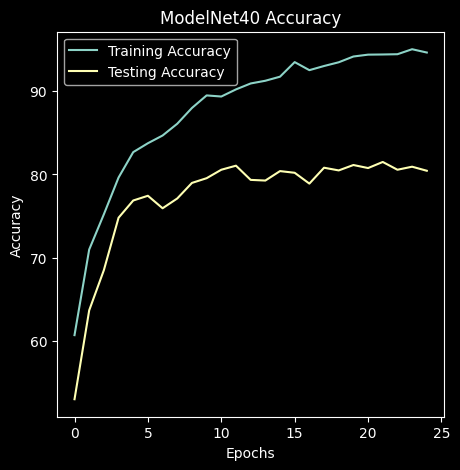

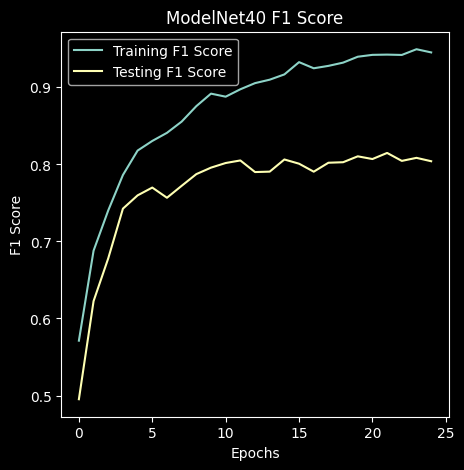

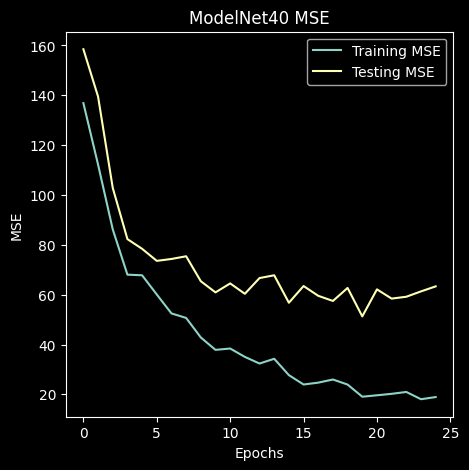

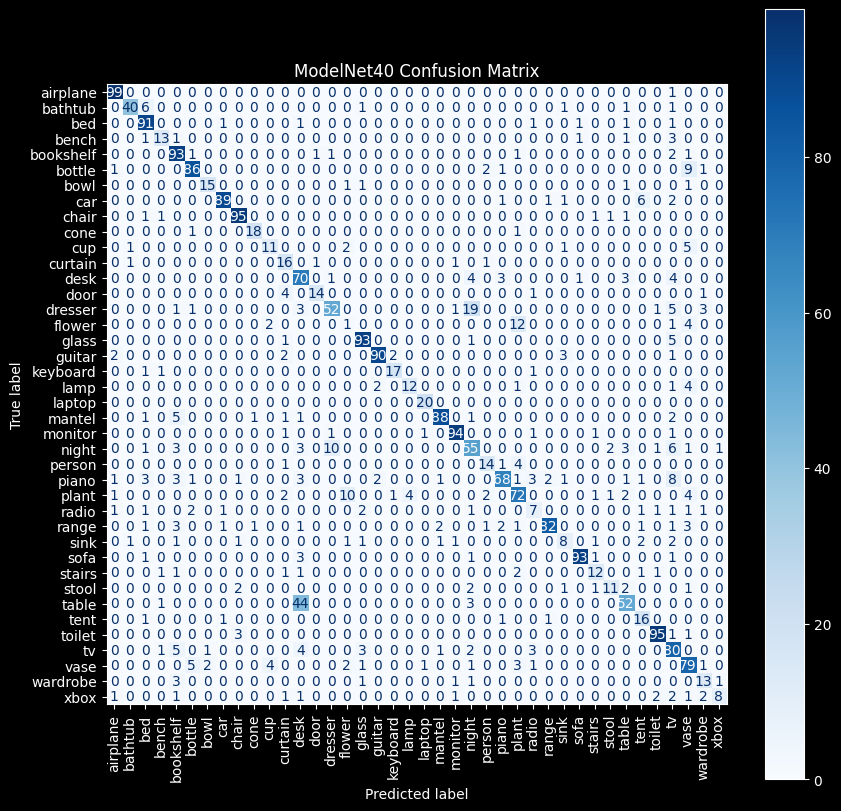

In [8]:
# Plot Accuracy
plt.figure(figsize=(5, 5))
plt.title(f'{training_set} Accuracy')
plt.plot(range(len(train_results['accuracies'])), train_results['accuracies'], label='Training Accuracy')
plt.plot(range(len(test_results['accuracies'])), test_results['accuracies'], label='Testing Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Plot F1 Score
plt.figure(figsize=(5, 5))
plt.title(f'{training_set} F1 Score')
plt.plot(range(len(train_results['f1_scores'])), train_results['f1_scores'], label='Training F1 Score')
plt.plot(range(len(test_results['f1_scores'])), test_results['f1_scores'], label='Testing F1 Score')
plt.legend()
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.show()

# Plot MSE
plt.figure(figsize=(5, 5))
plt.title(f'{training_set} MSE')
plt.plot(range(len(train_results['mses'])), train_results['mses'], label='Training MSE')
plt.plot(range(len(test_results['mses'])), test_results['mses'], label='Testing MSE')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

conf_matrix = test_results['conf_matrices'][-1]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
if training_set == "Toys4k":
    plt.figure(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
plt.title(f'{training_set} Confusion Matrix')
disp.plot(ax=plt.subplot(111), xticks_rotation='vertical', cmap=plt.cm.Blues, include_values=True, values_format='d')
plt.show()